In [2]:
import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
*  численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
*  туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
*  игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
*  игрок может совершать одно из двух действий:
  *  hit  — взять ещё одну карту;
  *  stand — не брать больше карт;
*  если сумма очков у игрока на руках больше 21, он проигрывает (bust);
*  если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
*  после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
*  в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [5]:
env_standart = gym.make('Blackjack-v0', natural=True)

iter = 100000
reward = np.zeros(iter)
for i in range(iter):
  s = env_standart.reset()
  done = False
  while not done:
    s, r, done, _ = env_standart.step(s[0] < 19)
    reward[i] += r
reward.mean()

-0.17748

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [3]:
def make_step(env, a):
  A = [False, True]
  return env.step(A[a])

def choose_a(Q, s, nA, eps):
  pi = np.ones(nA) * eps / nA
  best_a = np.random.randint(0, nA-1) if s not in Q else np.argmax(Q[s])
  pi[best_a] = 1 - eps + (eps / nA)
  return np.random.choice(np.arange(nA), p=pi)


def mc_control(step, env, nA=2, iter=500000, gamma=1.0, eps=0.9, alpha = 0.001, Q=None):
  if Q == None:
    Q = defaultdict(lambda: np.zeros(nA))

  for i in range(iter):
    s = env.reset()
    done = False
    episode = []
    while not done:
      a = choose_a(Q, s, nA, eps)
      s_next, r, done, _ = step(env, a)
      episode.append((s, a, r))
      s = s_next
    for i in range(len(episode)):
      s, a, r = episode[i]
      G = sum([episode[k + i][2] * (gamma ** k) for k in range(len(episode) - i)])
      Q[s][a] = Q[s][a] + (G - Q[s][a]) * alpha

  return Q

def play(step, Q, env, iter=100000):
  reward = np.zeros(iter)
  for i in range(iter):
    s = env.reset()
    done = False
    while not done:
      s, r, done, _ = step(env, np.argmax(Q[s]))
      reward[i] += r
  return reward.mean()

In [38]:
gamma = 0.8
eps = 0.6
alpha = 0.001
Q_1 = mc_control(make_step, env_standart, gamma=gamma, eps=eps, alpha=alpha)
print('gamma: ', gamma, '\teps: ', eps, '\talpha: ',alpha, '\t', play(make_step, Q_1, env_standart))

gamma:  0.8 	eps:  0.6 	alpha:  0.001 	 -0.04031


In [48]:
val = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
a = [0.001, 0.01, 0.1, 0.5, 1.0]
best_reward = -1
i = 0
for gamma in val:
  for eps in val:
    for alpha in a:
      Q_1 = mc_control(make_step, env_standart, gamma=gamma, eps=eps, alpha=alpha)
      reward = play(make_step, Q_1, env_standart)
      if reward > best_reward:
        best_reward = reward
        best_gamma = gamma
        best_eps = eps
        best_alpha = alpha
      i+=1
      print("\rCheck {}/{}.".format(i, 5*6*6), end="")
print('gamma: ', best_gamma, '\teps: ', best_eps, '\talpha: ',best_alpha, '\t', best_reward)

Check 180/180.gamma:  0.5 	eps:  0.7 	alpha:  0.01 	 -0.02359


3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [9]:
Q_1 = mc_control(make_step, env_standart, iter=5000, gamma=best_gamma, eps=best_eps, alpha=best_alpha)
reward = [play(make_step, Q_1, env_standart)]
for i in range(100): 
  Q_1 = mc_control(make_step, env_standart, iter=5000, gamma=best_gamma, eps=best_eps, alpha=best_alpha, Q=Q_1)
  reward.append(play(make_step, Q_1, env_standart))

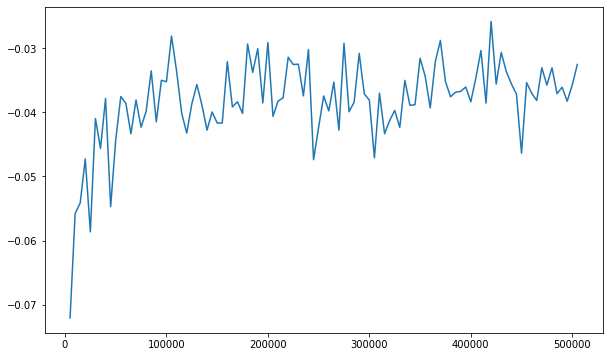

In [10]:
x = [(i + 1)*5000 for i in range(len(reward))]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(x, reward)

# Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.


4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [6]:
def make_step_with_double(env, a):
  if a != 2:
    return make_step(env, a)
  s, r, done, _ = env.step(True)
  if not done:
    s, r, done, _ = env.step(False)
  return s, 2 * r, done, _

In [53]:
gamma = 0.8
eps = 0.6
alpha = 0.001
Q_2 = mc_control(make_step_with_double, env_standart, nA=3, gamma=gamma, eps=eps, alpha=alpha)
print('gamma: ', gamma, '\teps: ', eps, '\talpha: ',alpha, '\t', play(make_step_with_double, Q_2, env_standart))

gamma:  0.8 	eps:  0.6 	alpha:  0.001 	 -0.0494


In [54]:
val = [0.5, 0.6, 0.7, 0.8, 0.9]
a = [0.001, 0.01, 0.1, 0.5]
best_reward = -1
i = 0
for gamma in val:
  for eps in val:
    for alpha in a:
      Q_2 = mc_control(make_step_with_double, env_standart, nA=3, gamma=gamma, eps=eps, alpha=alpha)
      reward = play(make_step_with_double, Q_2, env_standart)
      if reward > best_reward:
        best_reward = reward
        best_gamma = gamma
        best_eps = eps
        best_alpha = alpha
      i+=1
      print("\rCheck {}/{}.".format(i, 5*5*4), end="")
print('gamma: ', best_gamma, '\teps: ', best_eps, '\talpha: ',best_alpha, '\t', best_reward)

Check 100/100.gamma:  0.5 	eps:  0.6 	alpha:  0.01 	 -0.01779


5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [55]:
Q_2 = mc_control(make_step_with_double, env_standart, nA=3, iter=5000, gamma=best_gamma, eps=best_eps, alpha=best_alpha)
reward = [play(make_step_with_double, Q_2, env_standart)]
for i in range(100): 
  Q_2 = mc_control(make_step_with_double, env_standart, nA=3, iter=5000, gamma=best_gamma, eps=best_eps, alpha=best_alpha, Q=Q_2)
  reward.append(play(make_step_with_double, Q_2, env_standart))

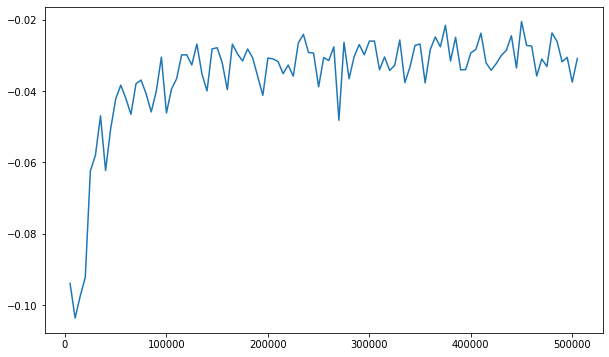

In [56]:
x = [(i + 1)*5000 for i in range(len(reward))]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(x, reward)

# Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.


6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет [статья википедии ](https://ru.wikipedia.org/wiki/Блэкджек)о блекджеке (а возможно, и нет).

In [7]:
def get_num(card):
    if card < 7:
      return 1
    if card > 9:
      return -1
    return 0
class Blackjack:
  

  def __init__(self):
    self.start_deck = ([i + 2 for i in range(10)] + [10] * 3) * 4
    self.deck = self.start_deck
    np.random.shuffle(self.deck)
    self.visible = 0
    self.player = []
    self.dealer = []

  def shuffle(self):
    self.deck = self.start_deck
    np.random.shuffle(self.deck)
    self.visible = 0

  def give_cards(self, n):
    cards = self.deck[-n:]
    self.deck = self.deck[:-n]
    return cards
  
  def _get_obs(self):
     return (sum(self.player), self.dealer[0], self.visible)

  def step(self, action):
    if action == True:
      self.player += self.give_cards(1)
      self.visible += get_num(self.player[-1])

      if sum(self.player) < 22:
        return self._get_obs(), 0.0, False, {}
      return self._get_obs(), -1.0, True, {}

    if action == False:
      self.visible += get_num(self.dealer[1])
      while sum(self.dealer) < 17:
        self.dealer += self.give_cards(1)
        self.visible += get_num(self.dealer[-1])
      if sum(self.dealer) < sum(self.player) or sum(self.dealer) > 21:
        if sum(self.player) == 21 and len(self.player) == 2:
          return self._get_obs, 1.5, True, {}
        return self._get_obs, 1.0, True, {}

      if sum(self.dealer) == sum(self.player):
        return self._get_obs(), 0.0, True, {}
      return self._get_obs(), -1.0, True, {}

  def reset(self):
    if len(self.deck) < 15:
      self.shuffle()
    self.player = self.give_cards(2)
    self.visible += get_num(self.player[0])
    self.visible += get_num(self.player[1])

    self.dealer = self.give_cards(2)
    self.visible += get_num(self.dealer[0])
    return self._get_obs()
    

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [9]:
env_Blackjack = Blackjack()
gamma = 0.8
eps = 0.6
alpha = 0.001
Q_3 = mc_control(make_step_with_double, env_Blackjack, nA=3, gamma=gamma, eps=eps, alpha=alpha)
print('gamma: ', gamma, '\teps: ', eps, '\talpha: ',alpha, '\t', play(make_step_with_double, Q_3, env_Blackjack))

gamma:  0.8 	eps:  0.6 	alpha:  0.001 	 -0.02564


In [10]:
val = [0.5, 0.6, 0.7, 0.8, 0.9]
a = [0.001, 0.01, 0.1, 0.5]
best_reward = -1
i = 0
for gamma in val:
  for eps in val:
    for alpha in a:
      Q_3 = mc_control(make_step_with_double, env_Blackjack, nA=3, gamma=gamma, eps=eps, alpha=alpha)
      reward = play(make_step_with_double, Q_3, env_Blackjack)
      if reward > best_reward:
        best_reward = reward
        best_gamma = gamma
        best_eps = eps
        best_alpha = alpha
      i+=1
      print("\rCheck {}/{}.".format(i, 5*5*4), end="")
print('gamma: ', best_gamma, '\teps: ', best_eps, '\talpha: ',best_alpha, '\t', best_reward)

Check 100/100.gamma:  0.6 	eps:  0.6 	alpha:  0.01 	 -0.001565


In [11]:
Q_3 = mc_control(make_step_with_double, env_Blackjack, nA=3, iter=5000, gamma=best_gamma, eps=best_eps, alpha=best_alpha)
reward = [play(make_step_with_double, Q_3, env_Blackjack)]
for i in range(100): 
  Q_3 = mc_control(make_step_with_double, env_Blackjack, nA=3, iter=5000, gamma=best_gamma, eps=best_eps, alpha=best_alpha, Q=Q_3)
  reward.append(play(make_step_with_double, Q_3, env_Blackjack))

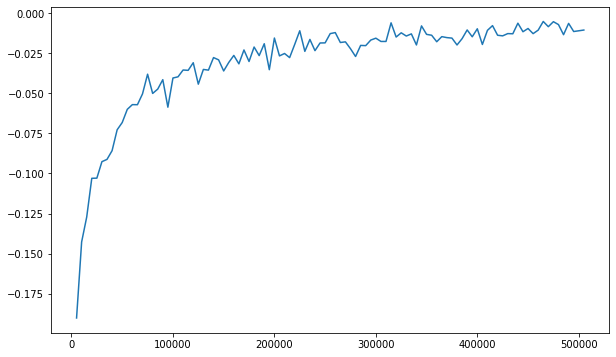

In [12]:
x = [(i + 1)*5000 for i in range(len(reward))]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(x, reward)